# **By Syeda Sania Bokhari**
# **1232868288**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **Basic preprocessing**

In [2]:
df = pd.read_csv("/content/telco_customer_churn-1.csv")

In [3]:
df.describe()

,churn,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,0.162147,0.299588,32.371149,0.783331,0.550192
std,0.441561,0.368612,0.458110,24.559481,0.412004,0.497510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000
75%,1.000000,0.000000,1.000000,55.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000


In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Display the first few rows to understand the structure
df.head()

,churn,senior_citizen,has_dependents,months_as_cutomer,has_internet_service,has_month_to_month_contract
0,0,0,0,1,1,1
1,0,0,0,34,1,0
2,1,0,0,2,1,1
3,0,0,0,45,1,0
4,1,0,0,2,1,1


In [5]:
df_encoded = pd.get_dummies(df, drop_first=True)

For converting any categorical variables to numerical representations we use one-hot encoding but in our case, the columns like senior_citizen, has_dependents, has_internet_service, and has_month_to_month_contract are already in binary (0 or 1) format, so no additional encoding is required.

The target variable is churn, where 1 means the customer churned, and 0 means they stayed. It's already in the correct format

In [6]:
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Separate features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Impute missing values if any
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# **Split data into training (70%) and testing (30%) sets**

In [7]:
# Standardize the features for K-NN and some clustering models
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Display shapes of datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4930, 5), (2113, 5), (4930,), (2113,))

# **Train and tune**

# Random Forests

In [8]:
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
rf_grid = GridSearchCV(
    rf, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1
)
# Use X_train instead of X_train_scaled
rf_grid.fit(X_train, y_train)


# Print best parameters and test set performance
print("Best params:", rf_grid.best_params_)
print("CV accuracy:", rf_grid.best_score_)
rf_best = rf_grid.best_estimator_
# Use X_test instead of X_test_scaled
print("Test accuracy:", accuracy_score(y_test, rf_best.predict(X_test)))

Best params: {'max_depth': 10, 'n_estimators': 100}
CV accuracy: 0.7645031466285981
Test accuracy: 0.7685754850922859


# XGBoost

In [9]:
!pip install xgboost
from xgboost import XGBClassifier
# Define the XGBoost model
xgb = XGBClassifier(random_state=42)

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Create GridSearchCV object
xgb_grid = GridSearchCV(
    xgb, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1
)

# Fit the model
xgb_grid.fit(X_train, y_train) # Use X_train here, assuming you want to use the same data as for RandomForest

# Print best parameters and test set performance
print("Best params:", xgb_grid.best_params_)
print("CV accuracy:", xgb_grid.best_score_)
xgb_best = xgb_grid.best_estimator_
print("Test accuracy:", accuracy_score(y_test, xgb_best.predict(X_test))) # Use X_test here

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
CV accuracy: 0.7823529644060008
Test accuracy: 0.7799337434926644


In [10]:

print("Best params:", xgb_grid.best_params_)
print("CV accuracy:", xgb_grid.best_score_)
xgb_best = xgb_grid.best_estimator_
print("Test accuracy:", accuracy_score(y_test, xgb_best.predict(X_test))) # Changed X_test_scaled to X_test

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
CV accuracy: 0.7823529644060008
Test accuracy: 0.7799337434926644


# K-Nearest Neighbors (K-NN)

In [11]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric':      ['euclidean', 'manhattan', 'minkowski'],
    'weights':     ['uniform', 'distance']
}

# 5. Grid search with 3‑fold CV
knn_grid = GridSearchCV(
    knn,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
# Use X_train instead of X_train_scaled. X_train was created using X_scaled in the train-test split
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [12]:
from sklearn.metrics import classification_report # Import classification_report

# 6. Evaluate best model
best_knn      = knn_grid.best_estimator_
best_params   = knn_grid.best_params_
best_cv_score = knn_grid.best_score_
y_pred        = best_knn.predict(X_test) # Changed X_test_scaled to X_test
test_acc      = accuracy_score(y_test, y_pred)

print("Best KNN parameters: ", best_params)
print(f"CV Accuracy (3‑fold): {best_cv_score:.4f}")
print(f"Test Set Accuracy:     {test_acc:.4f}\n")
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred)) # Assuming classification_report is imported

Best KNN parameters:  {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
CV Accuracy (3‑fold): 0.7712
Test Set Accuracy:     0.7492

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1539
           1       0.54      0.48      0.51       574

    accuracy                           0.75      2113
   macro avg       0.68      0.67      0.67      2113
weighted avg       0.74      0.75      0.74      2113



# K‑Means Clustering

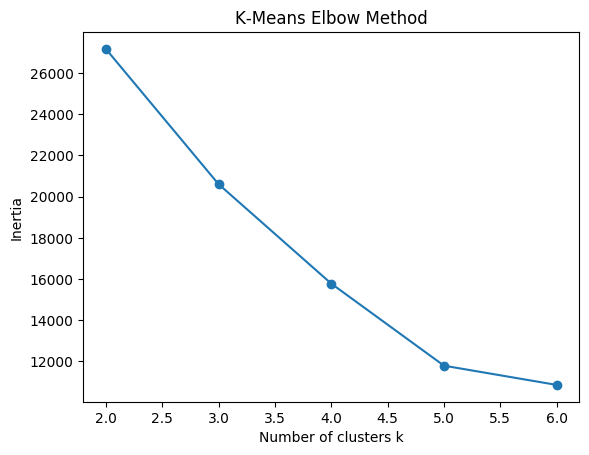

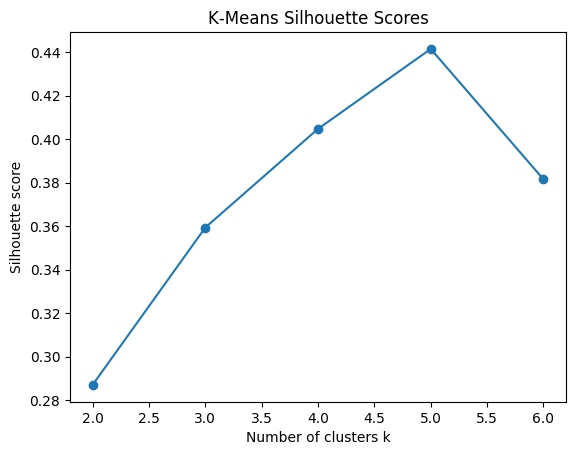

K‑Means Cluster Profiles:
                   churn     churn  senior_citizen  has_dependents  \
kmeans_cluster                                                       
0               0.150346  0.150346        0.001484        1.000000   
1               0.280526  0.280526        0.000000        0.000000   
2               0.417910  0.417910        1.000000        0.077261   

                months_as_cutomer  has_internet_service  \
kmeans_cluster                                            
0                       38.121167              0.681998   
1                       29.131376              0.785162   
2                       33.205443              0.956980   

                has_month_to_month_contract  kmeans_cluster  agg_cluster  
kmeans_cluster                                                            
0                                  0.365974             0.0     0.634520  
1                                  0.599691             1.0     0.429675  
2                          

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt # Import matplotlib.pyplot

inertia = []
sil_scores = []
K = range(2, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.figure()
plt.plot(K, inertia, marker='o')
plt.title('K‑Means Elbow Method')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.show()

# Silhouette plot
plt.figure()
plt.plot(K, sil_scores, marker='o')
plt.title('K‑Means Silhouette Scores')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.show()

# Choose an optimal k (e.g., k=3), fit and profile clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Assuming X_num contains the numerical features of your DataFrame
X_num = df.select_dtypes(include=np.number) # Define X_num to include numerical features

# Cluster profiles (mean churn rate and feature means)
print("K‑Means Cluster Profiles:")
print(df.groupby('kmeans_cluster')[['churn'] + list(X_num.columns)].mean())

# Hierarchical Clustering

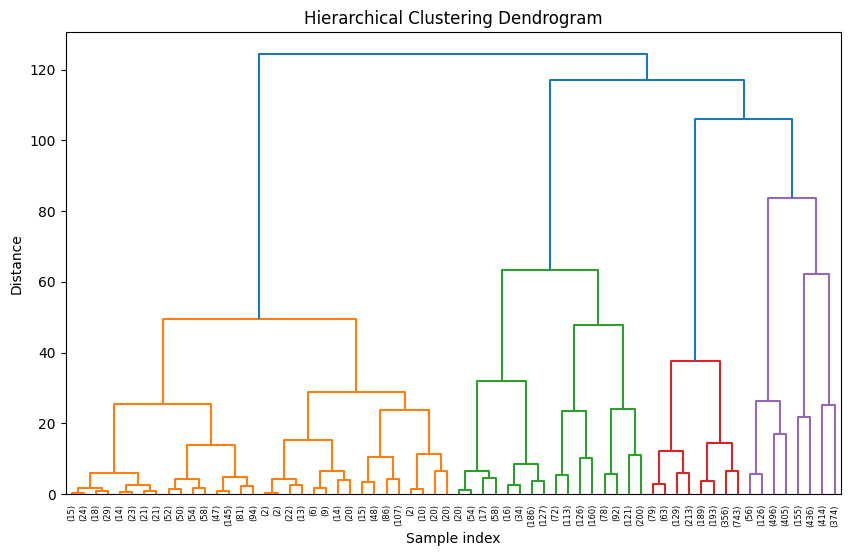


Hierarchical Cluster Profiles:
                churn     churn  senior_citizen  has_dependents  \
agg_cluster                                                       
0            0.290264  0.290264             0.0        0.311498   
1            0.416813  0.416813             1.0        0.079685   
2            0.073270  0.073270             0.0        0.434193   

             months_as_cutomer  has_internet_service  \
agg_cluster                                            
0                    32.863790              1.000000   
1                    33.295972              0.954466   
2                    30.175034              0.000000   

             has_month_to_month_contract  kmeans_cluster  
agg_cluster                                               
0                               0.577366        0.688502  
1                               0.706655        1.994746  
2                               0.347354        0.565807  


In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram # Import linkage and dendrogram
from sklearn.cluster import AgglomerativeClustering # Import AgglomerativeClustering

linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Assign clusters (e.g., 3 clusters)
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['agg_cluster'] = agg.fit_predict(X_scaled)

# Hierarchical cluster profiles
print("\nHierarchical Cluster Profiles:")
print(df.groupby('agg_cluster')[['churn'] + list(X_num.columns)].mean())

# **Compare performance using test set accuracy for classification models**

In [17]:
# Compute test‐set accuracies
rf_acc  = accuracy_score(y_test, rf_best.predict(X_test)) # Changed X_test_s to X_test
xgb_acc = accuracy_score(y_test, xgb_best.predict(X_test)) # Changed X_test_s to X_test
knn_acc = accuracy_score(y_test, knn_grid.best_estimator_.predict(X_test)) # Changed X_test_s to X_test, and since knn_best wasn't defined, I used knn_grid.best_estimator_ instead

# Create a comparison table
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Test Accuracy': [rf_acc, xgb_acc, knn_acc]
})

print(comparison.to_string(index=False))

        Model  Test Accuracy
Random Forest       0.768575
      XGBoost       0.779934
          KNN       0.749172


# **Interpret the cluster profiles and discuss their business value**

## Cluster 0 – “Mid‑Tenure, Internet Users”


Churn Rate: ~29%

Senior Citizens: 0% (all younger customers)

Dependents: ~31%

Avg. Tenure: ~33 months

Internet Service: 100% have it

Month‑to‑Month Contracts: ~58%

**Interpretation & Actions:**
This group is your “core” base of non‑senior, internet‑enabled subscribers who’ve been with you a couple of years. Their churn is lower than the oldest cohort but still substantial (nearly 3 in 10 leave). To lock them in:

Push 2‑yr or annual contracts with a loyalty discount (converting away from month‑to‑month).

Bundle in a value add (e.g. premium streaming service) to boost switching costs.

Offer a “refer a friend” bonus—they’re social (moderate dependents) and can bring in peers.



## Cluster 1 – “Senior Customers, High‑Risk”

Churn Rate: ~42% (highest)

Senior Citizens: 100%

Dependents: ~8% (mostly single or empty‑nesters)

Avg. Tenure: ~33 months

Internet Service: ~95%

Month‑to‑Month Contracts: ~71%

**Interpretation & Actions:**
All seniors on largely month‑to‑month plans are churning at the highest rate. This is a “vulnerable” segment:

Introduce a senior‑friendly long‑term plan (e.g. discounted 12‑mo) with easy auto‑renewal.

Provide white‑glove support (dedicated helpline) to address frustration before it leads to cancelation.

A small “welcome back” credit if they re‑up early—show them you value their loyalty.

## Cluster 2 – “No‑Internet, Low Churn”

Churn Rate: ~7% (lowest)

Senior Citizens: 0%

Dependents: ~43% (lots of families)

Avg. Tenure: ~30 months

Internet Service: 0% (no one has it)

Month‑to‑Month Contracts: ~35%

**Interpretation & Actions:**
These are long‑standing, family‑oriented customers without internet service—and they almost never leave. They represent a stable base but also an upsell opportunity:

Market your internet packages (family plans, high‑speed bundles) to this group—they trust you and have the household size to benefit.

Since their churn is minimal, focus on add‑on sales (e.g. security cameras, streaming add‑ons) rather than retention.

# **Business Value **

**Targeted Retention:** You know exactly which group to baby‑sit (Cluster 1 seniors) versus who needs standard loyalty perks (Cluster 0).

**Strategic Upsell:** Cluster 2’s low churn makes them prime for cross‑selling—growing ARPU without the risk of driving them away.

**Resource Allocation:** Instead of blanket discounts, you can tailor offers (contract length, support level, product bundles) to each segment’s unique profile—maximizing ROI on your retention and marketing spend.